### cleaning las vegas inspections dataset

- the southern nevada database contained information for all the cities in southern nevada including Las Vegas.
- this notebook aims to aggregate/ clean the las vegas dataset into 1 frame for further analysis.

In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine

from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

sys.path.append('../')
from envir import config
%matplotlib inline

#### connect & load data

In [2]:
engine = create_engine('postgresql+psycopg2:///yelp_abcs')
con = engine.connect

In [3]:
cities = pd.read_sql('select * from stag.nevada_restaurant_cities', con=engine)
cats = pd.read_sql('select * from stag.nevada_restaurant_categories', con=engine)
subcats = pd.read_sql('select * from stag.nevada_restaurant_pe_category_xref', con=engine)
restaurants = pd.read_sql('select * from stag.nevada_restaurant_establishments', con=engine)
inspection_types = pd.read_sql('select * from stag.nevada_restaurant_inspection_types', con=engine)
inspections = pd.read_sql('select * from stag.nevada_restaurant_inspections', con=engine)
violations = pd.read_sql('select * from stag.nevada_restaurant_violations', con=engine)

#### cities df

- 26 cities in the dataset including Las Vegas

In [4]:
cities.shape

(26, 2)

In [5]:
cities['city_name'].values

array(['Blue Diamond', 'Boulder City', 'Cal-Nev-Ari', 'Cottonwood Cove',
       'Glendale', 'Goodsprings', 'Henderson', 'Indian Springs', 'Jean',
       'Las Vegas', 'Laughlin', 'Lee Canyon', 'Logandale', 'Mesquite',
       'Moapa', 'North Las Vegas', 'Overton', 'Primm', 'Sandy Valley',
       'Searchlight', 'Coyote Springs', 'MT CHARLESTON', 'Pahrump',
       'Mountain Springs', 'Bunkerville', 'Palm Gardens'], dtype=object)

#### restaurants df
- 25,878 unique restaurants with 20,909 unique restaurants in Las Vegas
- level of uniqueness is at the permit level
- there are 30 different types of food establishments that get inspected included school kitchens

In [6]:
restaurants.shape

(25878, 21)

In [7]:
cats.shape

(30, 4)

In [8]:
cats['category_name'].values

array(['Bakery Sales', 'Banquet Kitchen', 'Banquet Support',
       'Bar / Tavern', 'Barbeque', 'Beer Bar', 'Buffet', 'Caterer',
       'Childcare Kitchens', 'Concessions', 'Confection',
       'Elementary School Kitchen', "Farmer's Market",
       'Frozen Meat Sales', 'Garde Manger', 'Grocery Store Sampling',
       'Institutional Food Service', 'Kitchen Bakery', 'Main Kitchen',
       'Meat/Poultry/Seafood', 'Food Trucks / Mobile Vendor', 'Pantry',
       'Portable Bar', 'Portable Unit', 'Produce Market', 'Restaurant',
       'Self-Service Food Truck', 'Snack Bar', 'Special Kitchen',
       'Vegetable Prep'], dtype=object)

In [9]:
subcats.shape

(84, 2)

In [10]:
cats = pd.merge(subcats, cats, on='category_id')
cats.drop(columns=['category_id', 'sort_order', 'active'], inplace=True)

In [11]:
restaurants = pd.merge(restaurants, cats, on='PE', how='left')

In [12]:
restaurants[restaurants['city_name']=='Las Vegas']['permit_number'].count()

20909

In [13]:
cat_counts = pd.DataFrame(restaurants[restaurants['city_name']=='Las Vegas'].groupby('category_name') \
                          ['permit_number'].nunique()).reset_index().sort_values('permit_number')

In [14]:
cat_counts.head()

,category_name,permit_number
5,Beer Bar,6
19,Main Kitchen,14
2,Banquet Support,24
8,Childcare Kitchens,41
29,Vegetable Prep,42


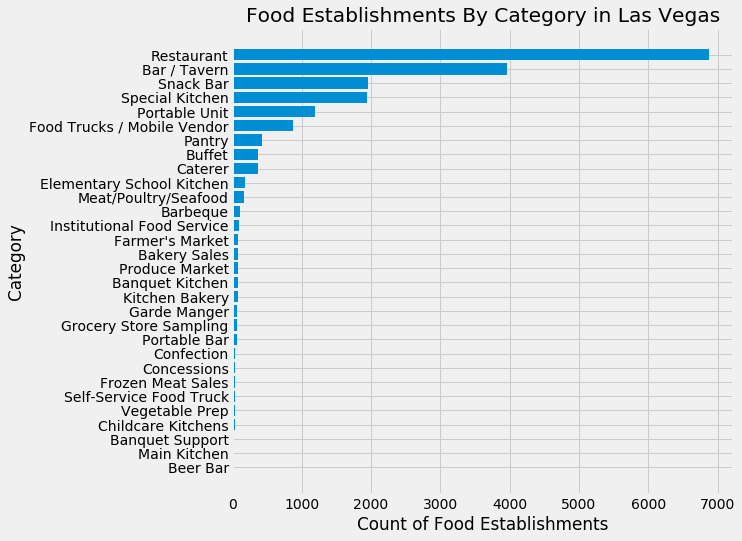

In [15]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(cat_counts['category_name'], cat_counts['permit_number'])
ax.set_title('Food Establishments By Category in Las Vegas')
plt.xlabel('Count of Food Establishments')
plt.ylabel('Category')
plt.savefig('FoodEstablishmentsByCategoryinLasVegas.png')

#### inspections df
- 259,268 unique inspections
- latest inspection is from 2019, looks like dataset is updated live
- earliest inspection is from 2000
- there are 7 different types of inspections, most of interest seems to be a) _**'Epidemiological Investigation'**_ and b)_**'Complaint Investigation'**_

In [16]:
inspections.shape

(259268, 15)

In [17]:
max(inspections.inspection_date)

'2019-11-22 00:00:00'

In [18]:
min(inspections.inspection_date)

'2000-07-30 00:00:00'

In [19]:
inspection_types['inspection_type'].values

array(['Epidemiological Investigation', 'Complaint Investigation',
       'Re-inspection', 'Routine Inspection',
       'Special Request Inspection', 'Survey', 'Final Remodel Inspection'],
      dtype=object)

In [20]:
inspections = pd.merge(inspections, inspection_types, how='inner', on ='inspection_type_id')

In [21]:
inspections.groupby('inspection_type')['serial_number'].nunique()

inspection_type
Re-inspection          18838
Routine Inspection    240381
Survey                    49
Name: serial_number, dtype: int64

kind of suprising that the only inspections are re-inspection, routine, and survey.

In [22]:
inspections['year'] = pd.DatetimeIndex(inspections['inspection_date']).year
inspections['month'] = pd.DatetimeIndex(inspections['inspection_date']).month
inspections['day'] = pd.DatetimeIndex(inspections['inspection_date']).day
inspections['hour'] = pd.DatetimeIndex(inspections['inspection_time']).hour

In [23]:
inspections.drop(columns=['owner_id'], inplace=True)

In [24]:
pd.merge(restaurants[restaurants['city_name']=='Las Vegas'], inspections, how='inner',
         left_on=('permit_number', 'facility_id'), right_on=('permit_number', 'facility_id')).shape

(206634, 39)

In [25]:
# joining restaurants with inspections data
res_ins = pd.merge(restaurants[restaurants['city_name']=='Las Vegas'], inspections, how='left',
                   left_on=('permit_number', 'facility_id'), right_on=('permit_number', 'facility_id'))

In [26]:
res_ins.shape

(207645, 39)

In [27]:
res_ins.head()

,permit_number,facility_id,owner_id,PE,restaurant_name,location_name,address,latitude,longitude,city_id,...,inspection_grade_new,permit_status,inspection_result,violations,record_updated,inspection_type,year,month,day,hour
0,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,A,None,Compliant,"13,34,35,36",2013-02-21 22:26:12,Routine Inspection,2005.0,3.0,23.0,12.0
1,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,A,None,Compliant,"13,14,31,32,36",2013-02-21 22:26:12,Routine Inspection,2006.0,1.0,22.0,8.0
2,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,A,None,Compliant,"13,14,25,27,35",2013-02-21 22:26:12,Routine Inspection,2006.0,3.0,15.0,17.0
3,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,A,None,Compliant,"23,31,35,37",2013-02-21 22:26:12,Routine Inspection,2007.0,6.0,19.0,12.0
4,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,B,None,B Downgrade,"4,16,27,30,31,36,37",2013-02-21 22:26:12,Routine Inspection,2008.0,6.0,23.0,20.0


In [28]:
res_ins.columns

Index(['permit_number', 'facility_id', 'owner_id', 'PE', 'restaurant_name',
       'location_name', 'address', 'latitude', 'longitude', 'city_id',
       'city_name', 'zip_code', 'nciaa', 'plan_review', 'record_status',
       'current_grade', 'current_demerits', 'date_current', 'previous_grade',
       'date_previous', 'search_text', 'category_name', 'serial_number',
       'inspection_date', 'inspection_time', 'employee_id',
       'inspection_type_id', 'inspection_demerits', 'inspection_grade',
       'inspection_grade_new', 'permit_status', 'inspection_result',
       'violations', 'record_updated', 'inspection_type', 'year', 'month',
       'day', 'hour'],
      dtype='object')

#### violations df

In [29]:
for i in violations['violation_demerits'].unique():
    print(i)
    print(violations[violations['violation_demerits']==i]['violation_description'].unique())

6
['Food not obtained from approved sources and/or improperly identified.'
 'Sewage not disposed into public sewer or approved facility. Cross-connections or back siphonage present.'
 'No hot and cold running water as required and/or water not from an approved source.'
 'Food spoiled or adulterated.'
 'Food workers improperly washing hands after using toilet'
 'Employee(s) working with boils' 'Poultry' 'Ground'
 'Pork and/or any food containing pork'
 'Potentially hazardous foods not kept at 40°F or colder or at 140°F or hotter']
2
['Fruits and vegetables improperly washed prior to serving.'
 'Potentially hazardous foods improperly thawed.'
 'Perishable foods kept at improper temperature.']
1
['Foods not stored off the floor.'
 'Required labels not present on food or containers of food.  Required signs not posted.'
 'Health cards not current on all food handlers.'
 'Unacceptable hygienic practices'
 'In-use utensils improperly handled and/or stored.'
 'Food and food storage containers 

*grouping violations into categories*

* minor - demerits of 1/2/3
* significant - demerits of 4/5/6
* crucial - violation demerits of 0 meaning imminent health hazard and 10 demerits


In [30]:
violations['minor'] =  [1 if (x == 1)|(x == 2)|(x==3) else 0 for x in violations['violation_demerits']]
violations['significant'] = [1 if (x == 4)|(x==5)|(x==6) else 0 for x in violations['violation_demerits']]
violations['crucial'] = [1 if (x == 0)|(x==10) else 0 for x in violations['violation_demerits']]

In [31]:
violations.head()

,violation_id,violation_code,violation_demerits,violation_description,minor,significant,crucial
0,1,1,6,Food not obtained from approved sources and/or...,0,1,0
1,15,15,6,Sewage not disposed into public sewer or appro...,0,1,0
2,16,16,6,No hot and cold running water as required and/...,0,1,0
3,17,17,2,Fruits and vegetables improperly washed prior ...,1,0,0
4,18,18,1,Foods not stored off the floor.,1,0,0


In [32]:
violations[violations['minor'] == 1]['violation_description']

3     Fruits and vegetables improperly washed prior ...
4                       Foods not stored off the floor.
5     Required labels not present on food or contain...
7        Health cards not current on all food handlers.
14                      Unacceptable hygienic practices
16    Food protected from potential contamination du...
17    Food protected from potential contamination by...
18    Effective pest control measures. Animals restr...
19               Hot and cold holding equipment present
20    Accurate thermometers (stem & hot/cold holding...
21                            PHF/TCSs properly thawed.
22    In-use utensils improperly handled and/or stored.
23              Single use items not reused or misused.
24    Person in charge available and knowledgeable/m...
25    Backflow prevention devices and methods in pla...
26    “B” or “C” grade card and required signs poste...
27    Food and food storage containers properly labe...
28    Appropriate sanitizer test kits provided a

In [33]:
violations['vid'] = violations['violation_id'].astype(str)

In [34]:
violations_dict = violations[['violation_id', 'violation_description']].set_index('violation_id').to_dict()

In [35]:
minor = np.array(violations[violations['minor']==1]['violation_id'])
crucial = np.array(violations[violations['crucial']==1]['violation_id'])
significant = np.array(violations[violations['significant']==1]['violation_id'])

Parse the violations string into individual violation codes and add up the groupings

In [36]:
split_inspections = res_ins['violations'].str.split(",", expand = True)
split_inspections.fillna(0, inplace=True)
split_inspections = split_inspections.astype('int64')

In [37]:
split_inspections['minor'] = 0
split_inspections['crucial'] = 0
split_inspections['significant'] = 0

for i in split_inspections:
    temp_minor =  [1 if x in minor else 0 for x in split_inspections[i]]
    temp_crucial = [1 if x in crucial else 0 for x in split_inspections[i]]
    temp_significant = [1 if x in significant else 0 for x in split_inspections[i]]
    
    split_inspections['minor'] = split_inspections['minor'] + temp_minor
    split_inspections['crucial'] = split_inspections['crucial'] + temp_crucial
    split_inspections['significant'] = split_inspections['significant'] + temp_significant

Concat the string of the violations

In [38]:
desc = pd.DataFrame(split_inspections.iloc[:, 0:41])

for i in desc:
    desc[i] = desc[i].map(violations_dict['violation_description'])
    
desc.fillna("", inplace=True)
desc = desc.astype(str)
desc['violations_desc'] = desc.apply(' '.join, axis=1)

In [39]:
res_ins = pd.concat([res_ins, split_inspections[['minor','crucial', 'significant']]], axis=1)
res_ins = pd.concat([res_ins, desc[['violations_desc']]], axis=1)

In [40]:
res_ins.head()

,permit_number,facility_id,owner_id,PE,restaurant_name,location_name,address,latitude,longitude,city_id,...,record_updated,inspection_type,year,month,day,hour,minor,crucial,significant,violations_desc
0,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,2013-02-21 22:26:12,Routine Inspection,2005.0,3.0,23.0,12.0,4,0,2,Unsuitable hand washing facilities No effectiv...
1,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,2013-02-21 22:26:12,Routine Inspection,2006.0,1.0,22.0,8.0,4,0,3,Unsuitable hand washing facilities Kitchenware...
2,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,2013-02-21 22:26:12,Routine Inspection,2006.0,3.0,15.0,17.0,4,0,3,Unsuitable hand washing facilities Kitchenware...
3,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,2013-02-21 22:26:12,Routine Inspection,2007.0,6.0,19.0,12.0,4,0,2,Facilities for washing and sanitizing equipmen...
4,PR0000002,FA0002677,None,1006,McDonald's #3549 D HOTEL,McDonalds (Store #3549) @ D HOTEL,301 Fremont St,36.16939,-115.143084,10,...,2013-02-21 22:26:12,Routine Inspection,2008.0,6.0,23.0,20.0,5,1,4,Inadequate hot and cold holding equipment No h...


#### exploratory data analysis

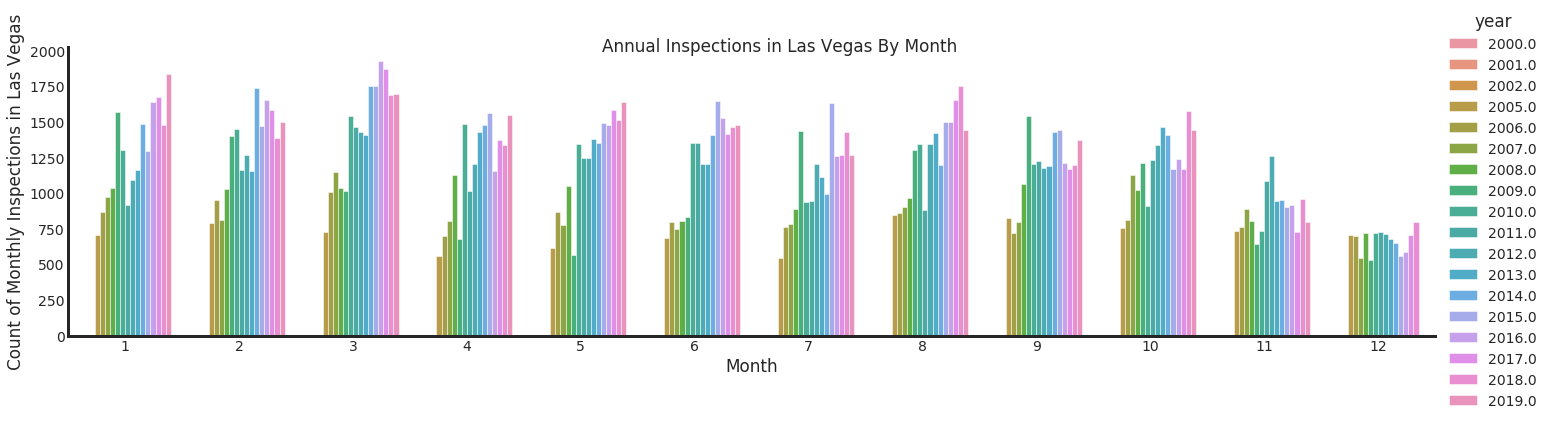

In [41]:
with sns.axes_style('white'):
    g = sns.catplot("month", data=res_ins,
                       aspect=4.0, kind='count',
                       hue='year', order=range(1, 13))
    g.set_ylabels('Count of Monthly Inspections in Las Vegas')
    g.set_xlabels('Month')
    g.fig.suptitle('Annual Inspections in Las Vegas By Month')


In [42]:
res_ins.groupby('inspection_result')['serial_number'].count()

inspection_result
A Grade                               50835
Approved                                144
Approved - Follow Up: Operations          3
B Downgrade                           16205
C Downgrade                            4816
Case Transfer/Referral                    1
Cease and Desist                          4
Closed with Fees                       1327
Closed without Fees                      93
Complaint Invalid/Unsubstantiated         4
Complaint valid with fee                  3
Complaint valid without fee               2
Compliance Schedule                      15
Compliant                            132529
Follow Up Required                       23
Inactive Status                          76
Meeting Required                          1
No Further Action                       194
Non-compliant                             2
Not Approved                              3
PR Change of Ownership Required           1
Permit Suspended                          6
Unspecified   

In [43]:
res_ins.groupby('inspection_result')[['minor', 'crucial', 'significant']].mean()

,minor,crucial,significant
inspection_result,,,
A Grade,0.465958,0.003659,1.045205
Approved,1.680556,0.013889,1.611111
Approved - Follow Up: Operations,0.333333,0.000000,0.666667
B Downgrade,2.988769,0.084912,3.085653
C Downgrade,5.503530,0.285091,4.018065
Case Transfer/Referral,0.000000,0.000000,2.000000
Cease and Desist,3.250000,0.250000,2.500000
Closed with Fees,4.762622,0.740015,4.165787
Closed without Fees,0.892473,0.301075,2.172043


In [44]:
annual_ins_counts = res_ins.groupby(['inspection_date', 
                                     'year', 'month', 'day'])['serial_number'].count().reset_index()

annual_ins_counts.set_index('inspection_date', inplace=True)

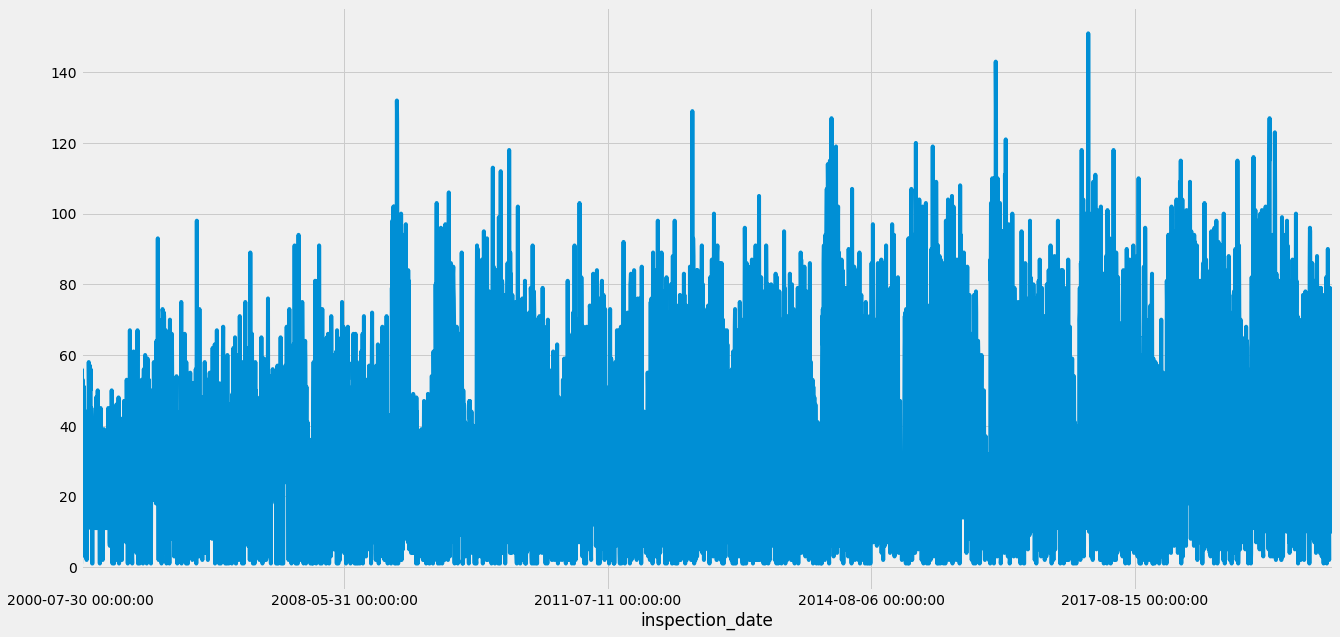

In [45]:
plt.figure(figsize=(20,10))
annual_ins_counts['serial_number'].plot()

In [46]:
res = sm.tsa.seasonal_decompose(annual_ins_counts['serial_number'],model='additive',freq=365) #try mult

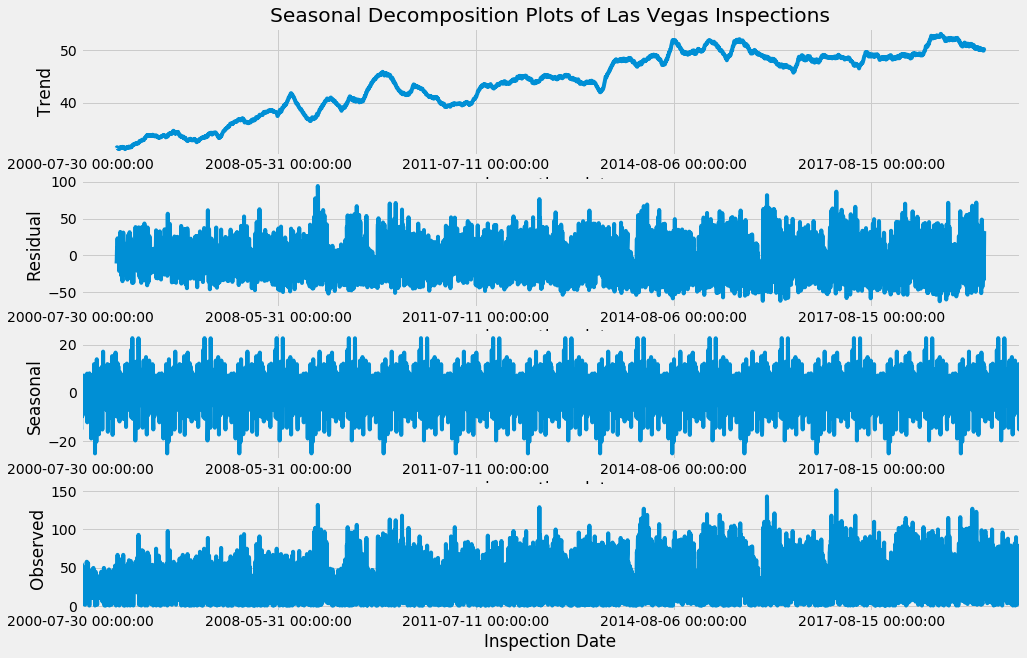

In [47]:
plt.style.use('fivethirtyeight')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,10))
res.trend.plot(ax=ax1)

ax1.set_title('Seasonal Decomposition Plots of Las Vegas Inspections')
ax1.set_ylabel('Trend')

res.resid.plot(ax=ax2)
ax2.set_ylabel('Residual')

res.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

res.observed.plot(ax=ax4)
ax4.set_ylabel('Observed')

plt.xlabel('Inspection Date')

plt.savefig('seasonal_decomposition_plots_of_las_vegas_inspections.png')

Text(0.5, 1.0, 'Histogram of the Count of Demerits Per Violation Type')

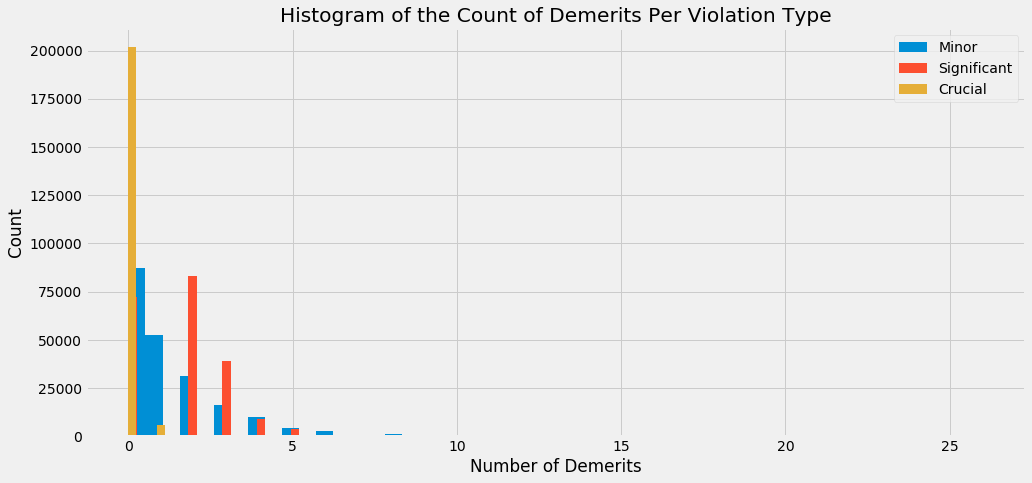

In [48]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1,1, figsize=(15,7))
res_ins[['minor']].hist(bins=50, ax=ax1, label='Minor')
res_ins[['significant']].hist(bins=50, ax=ax1, label='Significant')
res_ins[['crucial']].hist(bins=50, ax=ax1, label='Crucial')
ax1.legend()
plt.xlabel('Number of Demerits')
plt.ylabel('Count')
ax1.set_title('Histogram of the Count of Demerits Per Violation Type')

In [49]:
res_ins.columns

Index(['permit_number', 'facility_id', 'owner_id', 'PE', 'restaurant_name',
       'location_name', 'address', 'latitude', 'longitude', 'city_id',
       'city_name', 'zip_code', 'nciaa', 'plan_review', 'record_status',
       'current_grade', 'current_demerits', 'date_current', 'previous_grade',
       'date_previous', 'search_text', 'category_name', 'serial_number',
       'inspection_date', 'inspection_time', 'employee_id',
       'inspection_type_id', 'inspection_demerits', 'inspection_grade',
       'inspection_grade_new', 'permit_status', 'inspection_result',
       'violations', 'record_updated', 'inspection_type', 'year', 'month',
       'day', 'hour', 'minor', 'crucial', 'significant', 'violations_desc'],
      dtype='object')

In [50]:
odf = res_ins[['city_name', 'location_name', 'category_name', 'address', 'latitude', 'longitude',
               'inspection_time', 'violations_desc', 'minor', 'crucial', 'significant', 'inspection_result']]

In [51]:
odf.rename(columns={"city_name":"city",
                    "location_name":"name", 
                   "category_name":"establishment_type", 
                   "inspection_time":"inspection_date"},
          inplace=True)

/home/cusp/yg833/.conda/envs/yelpVE/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [52]:
try:
    odf.to_sql("clean_vegas_violations", engine, schema="clean")
except:
    print("table already exists")

table already exists
